<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_Resumen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resum**

---
Introducció al concepte de resum automàtic de textos (text summarization), una de les aplicacions més avançades i útils del processament del llenguatge natural (NLP) amb models Transformer, com T5, BART o LLaMA.

**Què és el text summarization?**

És una tasca de NLP que consisteix a:

1. Llegir i entendre un text llarg

1. Generar un resum breu i coherent que n’expressi les idees principals

**Per què és difícil?**

A diferència d’altres tasques com traducció o classificació de text, fer un bon resum requereix:

1. Comprensió profunda del contingut

1. Identificar les idees clau i ignorar el soroll

**Generar text nou que sigui:**

1. Gramaticalment correcte

1. Coherent

1. Fidel al significat original

1. És a dir, el model ha d’entendre, seleccionar i expressar, tot alhora.


Els models encoder-decoder com T5 o BART són especialment bons per aquesta tasca. Funcionen així:

* **Encoder**: Llegeix tot el text d’entrada i crea una representació interna rica.

* **Decoder**: A partir d’aquesta representació, genera el resum paraula a paraula.




# **Elaboració d'un corpus multilingüe**

---
El datset que conté ressenyes de productes d'Amazon escrites en sis idiomes (incloent-hi l'anglès i l'espanyol). Normalment, s'utilitza per entrenar o avaluar classificadors multilingües, és a dir, models que poden entendre i treballar amb més d'un idioma.

**Objectiu del quadern:**

L'objectiu és crear un model que pugui resumir ressenyes de productes en anglès i espanyol. Aquest model serà un resumidor bilingüe (bilingual summarizer), capaç de llegir textos llargs (ressenyes) i generar un resum curt (en aquest cas, un títol).

**Com s'utilitza el corpus?**

1. Text complet de la ressenya → s’utilitza com a entrada (input) del model.

1. Títol de la ressenya → s’utilitza com a resum esperat (target output o label) que el model ha d’aprendre a generar.

1. Això converteix el problema en una tasca de text summarization supervisada, ja que tens parelles "entrada-resposta".


In [ ]:
!pip install datasets
from datasets import load_dataset

spanish_dataset = load_dataset("neonwatty/amazon_reviews_multi", "es")
english_dataset = load_dataset("neonwatty/amazon_reviews_multi", "en")
english_dataset

# Descàrrega del dataset https://huggingface.co/datasets/mteb/amazon_reviews_multi

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)

In [ ]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["stars"].value_counts()[:20]

Es preparen les dades abans d’entrenar un model de resum automàtic bilingüe (anglès i espanyol). Et detallo el contingut pas a pas:

1. **Context: Domini de les dades**

"the reviews are not strictly about books..."

Vol dir que les ressenyes que tenim no són exclusivament sobre llibres, sinó també sobre calendaris, aplicacions com OneNote, etc. Tot i això, el contingut general (reviews de productes) continua sent adequat per entrenar un model de resum (summarization model).

2. **Objectiu: Crear un únic dataset bilingüe**

Per entrenar un únic model amb dades en anglès i espanyol, cal combinar els dos conjunts (english_dataset i spanish_dataset) en una única estructura de dades que contingui:

  * Les ressenyes (review_body) com a input

  * Els títols (review_title) com a resum esperat

I que barregi idiomes per evitar biaixos per ordre o idioma

In [14]:
from datasets import concatenate_datasets


In [15]:
bilingual_dataset = {}
for split in ["train", "validation", "test"]:
    combined = concatenate_datasets([english_dataset[split], spanish_dataset[split]])
    bilingual_dataset[split] = combined.shuffle(seed=42)


In [16]:
from datasets import DatasetDict
bilingual_dataset = DatasetDict(bilingual_dataset)


In [ ]:
show_samples(bilingual_dataset)

In [ ]:
bilingual_dataset

# **Preprocessat de les dades**

---
El següent pas el la tokenització, que és essencial abans d’entrenar qualsevol model de llenguatge com mT5. Et resumeixo i t’explico els punts clau:

1. **Objectiu del pas**

"tokenize and encode our reviews and their titles"

Vol dir que volem convertir el text en números que el model pugui entendre:

  * El cos de la ressenya (review_body) serà la entrada del model.

  * El títol de la ressenya (review_title) serà la sortida esperada (target o label) per al model.

2. **Què és tokenitzar?**

La tokenització és el procés de transformar frases en seqüències de tokens, que després es codifiquen en nombres enters que el model pot processar.

Exemple simplificat:



```
"El gat dorm" → ["▁El", "▁gat", "▁dorm"] → [101, 4023, 8734]
Aquests números representen les paraules al vocabulari del model.
```


3. **Per què carregar el tokenizer del model mT5?**

Per garantir que la tokenització sigui compatible amb el model que volem utilitzar, cal fer servir el mateix tokenizer amb què es va entrenar el model original.

En aquest cas, el model és google/mt5-small, que és:

  * Un model multilingüe (entén molts idiomes, inclòs l’espanyol i l’anglès).

  * Una versió petita (ràpida d'entrenar) de la família T5.


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Fem una ullada al funcionament
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

1. **Indicis del tokenitzador SentencePiece**

* ▁ (subratllat baix especial): indica l'inici d'una nova paraula.

`Per exemple: "el gat" → ["▁el", "▁gat"]`

  * SentencePiece no utilitza espais normals per separar paraules, sinó aquest símbol Unicode especial.

* </s>: és el token especial de final de seqüència.

El model sap que ha acabat de llegir o generar una frase quan troba aquest token.

Aquests detalls ens indiquen que s’està usant SentencePiece, un tokenitzador molt usat en models multilingües (com mT5, ByT5, MBart, etc.).

2. **Algorisme Unigram (usat per SentencePiece)**

L’algorisme Unigram parteix d’un gran conjunt de possibles fragments de paraula (subwords) i selecciona aquells que minimitzen una funció de pèrdua estadística global.

És especialment útil per:

  * Idiomes sense espais (com el japonès)

  * Textos amb moltes formes diferents d’escriptura (accents, puntuació...)

  * Això fa que funcioni molt bé amb dades multilingües.

3. **Truncament de ressenyes i títols**

Quan fem resum supervisat, tant:

  * entrada (review_body)

  * sortida esperada (review_title)

són textos que s’han de tokenitzar. Però el model té un límit màxim de longitud, per exemple 512 tokens. Així que cal truncar amb cura tant el text d’entrada com el de sortida, perquè:

  * Si són massa llargs, el model no podrà entrenar-se bé (o petarà la GPU).

  * La qualitat del resum millora si mantenim els textos dins de la longitud raonable.

In [22]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

El primer que hem fet és definir valors per a max_input_length i max_target_length, que estableixen els límits superiors de quant de temps poden durar les nostres ressenyes i títols. Com que el cos de la revisió sol ser molt més gran que el títol, hem escalat aquests valors en conseqüència.

Amb preprocess_function(), llavors és una qüestió senzilla tokenitzar tot el corpus mitjançant la pràctica funció Dataset.map() que hem utilitzat àmpliament al llarg d'aquest curs:

In [ ]:
tokenized_datasets = bilingual_dataset.map(preprocess_function, batched=True)

# **Rouge mètrica**

---
Avaluar la qualitat dels textos generats per un model, especialment en tasques com resum o traducció, on no hi ha una única resposta correcta.

1. **El problema: múltiples respostes vàlides**

"Given a review like “I loved reading the Hunger Games”..."

En tasques de generació de text, no hi ha una única resposta correcta. Per exemple, una ressenya podria resumir-se com:

```
“I loved the Hunger Games”

“Hunger Games is a great read”
```

Totes dues són bones, però si comparem literalment (caràcter per caràcter o paraula per paraula) amb una referència concreta, el model podria ser penalitzat injustament.

2. **Solució: la mètrica ROUGE**

Què és ROUGE?
ROUGE = Recall-Oriented Understudy for Gisting Evaluation

És una família de mètriques que mesura la similitud entre el text generat i un o diversos resums de referència (fets per humans). Es basa en comparar:

Paraules (ROUGE-1)

Bigrams (ROUGE-2)

Seqüències més llargues (ROUGE-L)

3. **Com es calcula?**

a) **Recall**
Mesura quanta informació del resum de referència ha estat capturada pel model:


​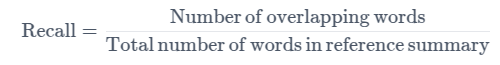

Si totes les paraules del resum de referència estan presents en el resum generat, el recall és 1 (perfecte).

b) **Precision**

Mesura quin percentatge del que ha generat el model realment és rellevant:

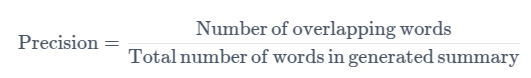

Un model pot tenir recall perfecte però precisió baixa si afegeix massa paraules inútils o redundants.



In [ ]:
!pip install rouge_score

In [ ]:
!pip install evaluate
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

In [ ]:
scores["rouge1"]

# **Creació d'un base-line sòlid**

---
Tècnica bàsica però útil que s'utilitza sovint com a línia base (baseline) en tasques de resumització de textos. Aquí tens el concepte detallat:

1. **Lead-3 baseline: Què és?**


El Lead-3 és una estratègia molt senzilla que consisteix a:

  * Agafar les tres primeres frases d’un text (normalment notícies o articles).

  * Considerar-les com el resum automàtic del text.

**Per què funciona?**

Perquè en molts textos periodístics o acadèmics:

* Les primeres frases condensen la informació més important (qui, què, quan, on...).

* És una manera fàcil d'obtenir un resum raonablement informatiu sense entrenar cap model.

**Problema: Detectar on acaben les frases**

Una manera naïf de detectar frases seria buscar els punts (.), però això falla fàcilment:

`“U.S.” o “Dr.” tenen punts però no marquen el final d’una frase.`

`Altres exemples: "Mr.", "e.g.", "etc."`

**Solució: usar nltk per detectar frases**

Nltk és una biblioteca de Python per processament de llenguatge natural. Inclou un segmentador de frases que:

1. Fa servir models estadístics i regles per detectar correctament on comença i acaba cada frase.

1. Té en compte abreviatures, puntuació, majúscules, etc.




In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

In [ ]:
import nltk

nltk.download('punkt_tab') # download the data package for English Punkt sentence tokenizer

from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(bilingual_dataset["train"][1]["review_body"]))

In [35]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [ ]:
import pandas as pd

score = evaluate_baseline(bilingual_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

# **Fine-tuning mT5 amb Keras**

---
Començar l’entrenament específic (fine-tuning) d’un model preentrenat per a una tasca de resumització. Aquí tens una explicació pas a pas del concepte:

1. **Què és el fine-tuning?**

El fine-tuning és el procés d’agafar un model preentrenat (com mT5-small) i reentrenar-lo lleugerament amb les teves dades específiques, per tal que s’ajusti millor a una tasca concreta (com ara generar resums de ressenyes).

1. **Per què no entrenem des de zero?**

Els models com mT5 ja han après:

  * Les estructures bàsiques de molts idiomes

  * El significat contextual de les paraules

  * Com generar frases coherents

Així doncs, només cal refinar aquest coneixement amb exemples específics de la tasca que ens interessa (resum).

3. **Resum = tasca seqüència a seqüència**

El resum és una seqüència a seqüència (seq2seq) perquè:

  * La entrada és una seqüència de text (ex: ressenya completa)

  * La sortida esperada és una altra seqüència de text (ex: títol o resum curt)

  * A diferència d’una tasca de classificació (on el resultat és una etiqueta), aquí el model ha de generar text.

4. **Quina classe s’utilitza per carregar el model?**

  * Aquesta classe (TFAutoModelForSeq2SeqLM) és part de la llibreria transformers de Hugging Face.

  * TF = Versió basada en TensorFlow (hi ha també AutoModelForSeq2SeqLM per a PyTorch)

  * Auto = Hugging Face detecta automàticament quin model carregar segons el checkpoint

  * Seq2SeqLM = Seqüència a Seqüència amb Language Modeling (capacitat de generar text)


In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [41]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [42]:
tokenized_datasets = tokenized_datasets.remove_columns(
    bilingual_dataset["train"].column_names
)

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

El més important a notar aquí és que el primer exemple és més llarg que el segon, de manera que els input_ids i l'attention_mask del segon exemple s'han encoixinat a la dreta amb un testimoni [PAD] (l'ID del qual és 0). De la mateixa manera, podem veure que les etiquetes s'han encoixinat amb -100, per assegurar-nos que la funció de pèrdua ignora els fitxes de farciment. I finalment, podem veure un nou decoder_input_ids que ha desplaçat les etiquetes cap a la dreta inserint un testimoni [PAD] a la primera entrada.

Ja estem gairebé a punt per entrenar! Només hem de convertir els nostres conjunts de dades a tf.data.Datasets utilitzant el col·lador de dades que hem definit anteriorment, i després compilar () i ajustar () el model. En primer lloc, els conjunts de dades:


In [44]:
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)
tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8,
)

In [45]:
from transformers import create_optimizer
import tensorflow as tf

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_epochs = 8
num_train_steps = len(tf_train_dataset) * num_train_epochs
model_name = model_checkpoint.split("/")[-1]

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(
    output_dir=f"{model_name}-finetuned-amazon-en-es", tokenizer=tokenizer
)

model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset, callbacks=[callback], epochs=8
)

Aquesta part aborda una part clau i avançada de l’avaluació de models de resumització amb TensorFlow: obtenir mètriques com ROUGE i millorar el rendiment de generació de text usant XLA (Accelerated Linear Algebra). Anem per parts:

1. **Pèrdua (loss) vs mètriques com ROUGE**

Durant l’entrenament veiem el valor de la funció de pèrdua (loss), que és útil per saber si el model està aprenent, però:

  * No ens diu directament si els resums són bons.

2. **Per tasques de generació de text, el més informatiu és calcular mètriques externes, com ROUGE.**

3. **Com s'obtenen les mètriques ROUGE**

Per calcular ROUGE, cal:

  * Fer que el model generi text a partir de les entrades (reviews).

  * Comparar els resultats amb els resums de referència (titles).

  * Convertir prediccions i referències a strings.

  * Passar-les a evaluate.load("rouge").

4. **Millorar el rendiment amb XLA**

XLA (Accelerated Linear Algebra) és un compilador que optimitza el gràfic de computació de TensorFlow:

  * Redueix temps d’execució

  * Estalvia memòria

  * Fa que la generació de text sigui molt més eficient

5. **Com aplicar XLA**

Paddar entrades a múltiples de 128

Per maximitzar el rendiment, cal que totes les entrades tinguin formes similars (mateix nombre de tokens). Això es pot fer paddant a longituds múltiples de 128, per exemple: 128, 256, 384...

In [ ]:
from tqdm import tqdm
import numpy as np

generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=320
)

tf_generate_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=generation_data_collator,
    shuffle=False,
    batch_size=8,
    drop_remainder=True,
)


@tf.function(jit_compile=True)
def generate_with_xla(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=32,
    )


all_preds = []
all_labels = []
for batch, labels in tqdm(tf_generate_dataset):
    predictions = generate_with_xla(batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = labels.numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

In [ ]:
result = rouge_score.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True
)
result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
{k: round(v, 4) for k, v in result.items()}

# **Utilitzant el vostre model ajustat**

---



In [ ]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
def print_summary(idx):
    review = bilingual_dataset["test"][idx]["review_body"]
    title = bilingual_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [ ]:
print_summary(100)

In [ ]:
print_summary(0)